In [1]:
import torch
import torchvision
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
from torch.autograd import Variable
from tf2onnx import convert
import numpy as np


/opt/conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-16 04:55:38.265139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 04:55:39.054525: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 04:55:41.356763: W tensorflow/compiler/xla/stream_executor/platform/default/dso

In [2]:
import argparse
from model_src.comp_graph.tf_comp_graph import ComputeGraph, OP2I

In [87]:
op2i = OP2I().build_from_file()
new_cg = ComputeGraph(name="efficientnet", H=64, W=64, C_in=3)
new_cg.build_from_pb('/home/ec2-user/nas-rec-engine/GENNAPE_Files/efficientnet-b0.pb', op2i, oov_threshold=0.)

([conv2d[op_type_idx=3
  shape=[3, 32, 3, 3]
  res=(224, 112, 224, 112, 3, 32)],
  depthwise[op_type_idx=4
  shape=[32, 1, 3, 3]
  res=(112, 112, 112, 112, 32, 32)],
  conv2d[op_type_idx=3
  shape=[32, 8, 1, 1]
  res=(1, 1, 1, 1, 32, 8)],
  conv2d[op_type_idx=3
  shape=[8, 32, 1, 1]
  res=(1, 1, 1, 1, 8, 32)],
  conv2d[op_type_idx=3
  shape=[32, 16, 1, 1]
  res=(112, 112, 112, 112, 32, 16)],
  conv2d[op_type_idx=3
  shape=[16, 96, 1, 1]
  res=(112, 112, 112, 112, 16, 96)],
  depthwise[op_type_idx=4
  shape=[96, 1, 3, 3]
  res=(112, 56, 112, 56, 96, 96)],
  conv2d[op_type_idx=3
  shape=[96, 4, 1, 1]
  res=(1, 1, 1, 1, 96, 4)],
  conv2d[op_type_idx=3
  shape=[4, 96, 1, 1]
  res=(1, 1, 1, 1, 4, 96)],
  conv2d[op_type_idx=3
  shape=[96, 24, 1, 1]
  res=(56, 56, 56, 56, 96, 24)],
  conv2d[op_type_idx=3
  shape=[24, 144, 1, 1]
  res=(56, 56, 56, 56, 24, 144)],
  depthwise[op_type_idx=4
  shape=[144, 1, 3, 3]
  res=(56, 56, 56, 56, 144, 144)],
  conv2d[op_type_idx=3
  shape=[144, 6, 1, 1]
  r

In [75]:
new_cg.gviz_visualize(view=True, filename="efficientnet_graph", output_dir="graphs")

In [4]:
from model_src.comp_graph.tf_comp_graph_dataloaders import CGRegressDataLoader
from tqdm import tqdm
from model_src.comp_graph.tf_comp_graph_models import make_cg_regressor, make_embedding_model, make_embedding_regressor_model
import torch_geometric
from utils.model_utils import set_random_seed, device, add_weight_decay, get_activ_by_name


In [76]:
loader = CGRegressDataLoader(1, [(new_cg, 0)])

Building batches: 100%|##########| 1/1 [00:00<00:00, 217.74it/s]


In [3]:
from params import *

def _batch_fwd_func(_model, _batch):
        # Define how a batch is handled by the model
        regular_node_inds = _batch[DK_BATCH_CG_REGULAR_IDX]
        regular_node_shapes = _batch[DK_BATCH_CG_REGULAR_SHAPES]
        weighted_node_inds = _batch[DK_BATCH_CG_WEIGHTED_IDX]
        weighted_node_shapes = _batch[DK_BATCH_CG_WEIGHTED_SHAPES]
        weighted_node_kernels = _batch[DK_BATCH_CG_WEIGHTED_KERNELS]
        weighted_node_bias = _batch[DK_BATCH_CG_WEIGHTED_BIAS]
        edge_tsr_list = _batch[DK_BATCH_EDGE_TSR_LIST]
        batch_last_node_idx_list = _batch[DK_BATCH_LAST_NODE_IDX_LIST]
        return _model(regular_node_inds, regular_node_shapes,
                      weighted_node_inds, weighted_node_shapes, weighted_node_kernels, weighted_node_bias,
                      edge_tsr_list, batch_last_node_idx_list)

In [7]:
def gnn_constructor(in_channels, out_channels):
        nn = torch.nn.Sequential(torch.nn.Linear(in_channels, in_channels),
                                torch.nn.Linear(in_channels, out_channels),
                                )
        return torch_geometric.nn.GINConv(nn=nn)

In [35]:
model = make_embedding_regressor_model(n_unique_labels=len(OP2I().build_from_file()), out_embed_size=128,
                              shape_embed_size=8, kernel_embed_size=8, n_unique_kernels=8, n_shape_vals=6,
                              hidden_size=128, out_channels=128,
                              gnn_constructor=gnn_constructor,
                              gnn_activ=get_activ_by_name("relu"), n_gnn_layers=6,
                              dropout_prob=0.3, aggr_method="gnn",
                              regressor_activ=get_activ_by_name(None)).to(device())

In [37]:
from utils.model_utils import model_load
from constants import *

checkpoint_file = "/home/ec2-user/nas-rec-engine/saved_models/gpi_acc_predictor_CL_dropout_encoder_decoder_regression_model_seed109_best.pt"
if os.path.isfile(checkpoint_file):
    sd = model_load(checkpoint_file)
    try:
        model.load_state_dict(sd[CHKPT_MODEL], strict=True)
    except Exception:
        # Handles the thop bug
        state_dict = []
        for n, p in sd[CHKPT_MODEL].items():
            if "total_ops" not in n and "total_params" not in n:
                state_dict.append((n, p))
        model.load_state_dict(dict(state_dict), strict=strict)
    print(sd[CHKPT_BEST_EVAL_RESULT],sd[CHKPT_BEST_EVAL_ITERATION])

3.759347279549108 97


In [77]:
model = model.to(device())
with torch.no_grad():
        model.eval()
        batch_vals = []
        for batch in tqdm(loader, desc="Dev", ascii=True):
                batch_vals = _batch_fwd_func(model, batch)
        print(batch_vals)

Dev: 100%|##########| 1/1 [00:00<00:00, 138.41it/s]

tensor([[-1.7427]], device='cuda:0')


In [40]:
new_cg.edge_pairs

[(0, 24),
 (1, 28),
 (2, 31),
 (3, 30),
 (4, 34),
 (5, 36),
 (6, 39),
 (7, 42),
 (8, 41),
 (9, 45),
 (10, 47),
 (11, 50),
 (12, 53),
 (13, 52),
 (14, 56),
 (15, 58),
 (16, 61),
 (17, 64),
 (18, 63),
 (19, 67),
 (20, 69),
 (21, 73),
 (22, 23),
 (23, 0),
 (24, 25),
 (25, 26),
 (26, 27),
 (27, 1),
 (27, 2),
 (28, 29),
 (29, 3),
 (30, 32),
 (31, 32),
 (32, 33),
 (33, 4),
 (33, 37),
 (34, 35),
 (35, 5),
 (36, 37),
 (37, 38),
 (38, 6),
 (38, 7),
 (39, 40),
 (40, 8),
 (41, 43),
 (42, 43),
 (43, 44),
 (44, 9),
 (44, 48),
 (45, 46),
 (46, 10),
 (47, 48),
 (48, 49),
 (49, 11),
 (49, 12),
 (50, 51),
 (51, 13),
 (52, 54),
 (53, 54),
 (54, 55),
 (55, 14),
 (55, 59),
 (56, 57),
 (57, 15),
 (58, 59),
 (59, 60),
 (60, 16),
 (60, 17),
 (61, 62),
 (62, 18),
 (63, 65),
 (64, 65),
 (65, 66),
 (66, 19),
 (66, 70),
 (67, 68),
 (68, 20),
 (69, 70),
 (70, 71),
 (71, 72),
 (72, 21)]

In [80]:
node_id2idx = {n.str_id: i for i, n in enumerate(new_cg.nodes)}

In [47]:
node_id2idx

{'135|resnet18/conv1/conv2d': 0,
 '148|resnet18/res2a_branch2a/conv2d': 1,
 '158|resnet18/res2a_branch1/conv2d': 2,
 '162|resnet18/res2a_branch2b/conv2d': 3,
 '178|resnet18/res2b_branch2a/conv2d': 4,
 '188|resnet18/res2b_branch2b/conv2d': 5,
 '199|resnet18/res3a_branch2a/conv2d': 6,
 '209|resnet18/res3a_branch1/conv2d': 7,
 '213|resnet18/res3a_branch2b/conv2d': 8,
 '229|resnet18/res3b_branch2a/conv2d': 9,
 '239|resnet18/res3b_branch2b/conv2d': 10,
 '250|resnet18/res4a_branch2a/conv2d': 11,
 '260|resnet18/res4a_branch1/conv2d': 12,
 '264|resnet18/res4a_branch2b/conv2d': 13,
 '280|resnet18/res4b_branch2a/conv2d': 14,
 '290|resnet18/res4b_branch2b/conv2d': 15,
 '301|resnet18/res5a_branch2a/conv2d': 16,
 '311|resnet18/res5a_branch1/conv2d': 17,
 '315|resnet18/res5a_branch2b/conv2d': 18,
 '331|resnet18/res5b_branch2a/conv2d': 19,
 '341|resnet18/res5b_branch2b/conv2d': 20,
 '354|resnet18/fc1000/matmul': 21,
 '3|input': 22,
 '132|resnet18/conv1_pad/pad/paddings': 23,
 '142|resnet18/bn_conv1/f

In [48]:
new_cg.weighted_nodes

[conv2d[op_type_idx=3
 shape=[3, 64, 7, 7]
 res=(230, 112, 230, 112, 3, 64)],
 conv2d[op_type_idx=3
 shape=[64, 64, 3, 3]
 res=(56, 56, 56, 56, 64, 64)],
 conv2d[op_type_idx=3
 shape=[64, 64, 1, 1]
 res=(56, 56, 56, 56, 64, 64)],
 conv2d[op_type_idx=3
 shape=[64, 64, 3, 3]
 res=(56, 56, 56, 56, 64, 64)],
 conv2d[op_type_idx=3
 shape=[64, 64, 3, 3]
 res=(56, 56, 56, 56, 64, 64)],
 conv2d[op_type_idx=3
 shape=[64, 64, 3, 3]
 res=(56, 56, 56, 56, 64, 64)],
 conv2d[op_type_idx=3
 shape=[64, 128, 3, 3]
 res=(56, 28, 56, 28, 64, 128)],
 conv2d[op_type_idx=3
 shape=[64, 128, 1, 1]
 res=(56, 28, 56, 28, 64, 128)],
 conv2d[op_type_idx=3
 shape=[128, 128, 3, 3]
 res=(28, 28, 28, 28, 128, 128)],
 conv2d[op_type_idx=3
 shape=[128, 128, 3, 3]
 res=(28, 28, 28, 28, 128, 128)],
 conv2d[op_type_idx=3
 shape=[128, 128, 3, 3]
 res=(28, 28, 28, 28, 128, 128)],
 conv2d[op_type_idx=3
 shape=[128, 256, 3, 3]
 res=(28, 14, 28, 14, 128, 256)],
 conv2d[op_type_idx=3
 shape=[128, 256, 1, 1]
 res=(28, 14, 28, 14

In [79]:
positions = new_cg.get_relative_node_positions()
id_2_pos = {new_cg.nodes[i].str_id : positions[i] for i in range(len(new_cg.nodes))}

In [53]:
for wn in new_cg.weighted_nodes:
    print(wn.str_id, id_2_pos[wn.str_id])

135|resnet18/conv1/conv2d 0.04054054054054054
148|resnet18/res2a_branch2a/conv2d 0.10810810810810811
158|resnet18/res2a_branch1/conv2d 0.12162162162162163
162|resnet18/res2a_branch2b/conv2d 0.1891891891891892
178|resnet18/res2b_branch2a/conv2d 0.22972972972972974
188|resnet18/res2b_branch2b/conv2d 0.32432432432432434
199|resnet18/res3a_branch2a/conv2d 0.2972972972972973
209|resnet18/res3a_branch1/conv2d 0.3108108108108108
213|resnet18/res3a_branch2b/conv2d 0.40540540540540543
229|resnet18/res3b_branch2a/conv2d 0.44594594594594594
239|resnet18/res3b_branch2b/conv2d 0.5405405405405406
250|resnet18/res4a_branch2a/conv2d 0.5135135135135135
260|resnet18/res4a_branch1/conv2d 0.527027027027027
264|resnet18/res4a_branch2b/conv2d 0.6216216216216216
280|resnet18/res4b_branch2a/conv2d 0.6621621621621622
290|resnet18/res4b_branch2b/conv2d 0.7567567567567568
301|resnet18/res5a_branch2a/conv2d 0.7297297297297297
311|resnet18/res5a_branch1/conv2d 0.7432432432432432
315|resnet18/res5a_branch2b/conv2d 

In [54]:
len(new_cg.weighted_nodes)

22

In [59]:
from model_src.comp_graph.tf_comp_graph import remove_node_edges, get_reverse_adj_dict
import copy

In [57]:
def prune_specific_node(nodes, src_id2dst_ids, eliminate_id):
    # Remove any internal input/output nodes
    dst_id2src_ids = get_reverse_adj_dict(src_id2dst_ids)
    pruned_ids = set()
    for i, n in enumerate(nodes):
        if n.str_id == eliminate_id:
            pruned_ids.add(n.str_id)
            remove_node_edges(n, src_id2dst_ids, dst_id2src_ids)
    kept_nodes = [n for n in nodes if n.str_id not in pruned_ids]
    return kept_nodes, src_id2dst_ids

In [64]:
new_cg_copy = copy.deepcopy(new_cg)

In [65]:
node = new_cg_copy.weighted_nodes[0]
new_cg_copy.n_weighted_nodes -= 1
new_cg_copy.weighted_nodes = new_cg_copy.weighted_nodes[1:]
edge_pairs = []
for src, dst in new_cg_copy.edge_pairs:
    if src != node_id2idx[node.str_id] and dst != node_id2idx[node.str_id]:
        edge_pairs.append((src, dst))
    else:
        print(src, dst)
new_cg_copy.edge_pairs = edge_pairs

0 24
23 0


In [93]:
n = len(new_cg.weighted_nodes)
cg_list = []
batch_vals = []
for i in range(n):
        new_cg_copy = copy.deepcopy(new_cg)
        node = new_cg_copy.weighted_nodes[i]
        new_cg_copy.n_weighted_nodes -= 1
        #new_cg_copy.weighted_nodes.pop(i)
        
        edge_pairs = []
        for src, dst in new_cg_copy.edge_pairs:
                if src != node_id2idx[node.str_id] and dst != node_id2idx[node.str_id]:
                        edge_pairs.append((src, dst))
                else:
                        print(src, dst)
        
        new_cg_copy.edge_pairs = edge_pairs
        print(new_cg_copy)

        loader = CGRegressDataLoader(1, [(new_cg_copy, 0)])
        model = model.to(device())
        with torch.no_grad():
                model.eval()
                for batch in tqdm(loader, desc="Dev", ascii=True):
                        batch = _batch_fwd_func(model, batch)
                        batch_vals.append(batch)
print(batch_vals)


0 83
82 0
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 143.89it/s]


1 86
85 1
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 187.39it/s]


2 90
2 91
89 2
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.80it/s]


3 92
91 3
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 189.23it/s]


4 94
93 4
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 189.39it/s]


5 96
95 5
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 183.24it/s]


6 99
98 6
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 186.26it/s]


7 103
7 104
102 7
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 187.48it/s]


8 105
104 8
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 188.28it/s]


9 107
106 9
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 131.48it/s]


10 109
108 10
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 143.92it/s]


11 112
111 11
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 124.53it/s]


12 116
12 117
115 12
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 177.08it/s]


13 118
117 13
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 134.19it/s]


14 120
119 14
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 163.96it/s]


15 123
122 15
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 161.61it/s]


16 126
125 16
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 156.60it/s]


17 130
17 131
129 17
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 181.49it/s]


18 132
131 18
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 173.50it/s]


19 134
133 19
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 147.42it/s]


20 136
135 20
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 178.79it/s]


21 139
138 21
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.24it/s]


22 143
22 144
142 22
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 188.56it/s]


23 145
144 23
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 188.70it/s]


24 147
146 24
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 186.45it/s]


25 150
149 25
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 185.73it/s]


26 153
152 26
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 183.42it/s]


27 157
27 158
156 27
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 186.17it/s]


28 159
158 28
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 175.20it/s]


29 161
160 29
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 182.58it/s]


30 163
162 30
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 162.51it/s]


31 166
165 31
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 185.48it/s]


32 170
32 171
169 32
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.21it/s]


33 172
171 33
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 192.43it/s]


34 174
173 34
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.15it/s]


35 177
176 35
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.29it/s]


36 180
179 36
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.72it/s]


37 184
37 185
183 37
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.25it/s]


38 186
185 38
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.13it/s]


39 188
187 39
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 192.66it/s]


40 191
190 40
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.66it/s]


41 194
193 41
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 195.61it/s]


42 198
42 199
197 42
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.57it/s]


43 200
199 43
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.07it/s]


44 202
201 44
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.80it/s]


45 204
203 45
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 196.22it/s]


46 207
206 46
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.62it/s]


47 211
47 212
210 47
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 194.87it/s]


48 213
212 48
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.14it/s]


49 215
214 49
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.84it/s]


50 218
217 50
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.89it/s]


51 221
220 51
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.90it/s]


52 225
52 226
224 52
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.58it/s]


53 227
226 53
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 186.21it/s]


54 229
228 54
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 189.67it/s]


55 232
231 55
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 186.45it/s]


56 235
234 56
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 189.83it/s]


57 239
57 240
238 57
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 190.37it/s]


58 241
240 58
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.63it/s]


59 243
242 59
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 189.58it/s]


60 245
244 60
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 189.42it/s]


61 248
247 61
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 188.66it/s]


62 252
62 253
251 62
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.32it/s]


63 254
253 63
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 190.39it/s]


64 256
255 64
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.14it/s]


65 259
258 65
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.22it/s]


66 262
261 66
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 179.03it/s]


67 266
67 267
265 67
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 167.15it/s]


68 268
267 68
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 176.59it/s]


69 270
269 69
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 139.61it/s]


70 273
272 70
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 178.12it/s]


71 276
275 71
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 178.25it/s]


72 280
72 281
279 72
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 169.15it/s]


73 282
281 73
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 190.12it/s]


74 284
283 74
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.72it/s]


75 287
286 75
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.23it/s]


76 290
289 76
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.82it/s]


77 294
77 295
293 77
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 376)


Dev: 100%|##########| 1/1 [00:00<00:00, 191.04it/s]


78 296
295 78
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 192.31it/s]


79 298
297 79
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 193.00it/s]


80 300
299 80
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 148.12it/s]


81 305
304 81
ComputeGraph[efficientnet](n_nodes: 306, n_edges: 377)


Dev: 100%|##########| 1/1 [00:00<00:00, 197.36it/s]


[tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1.7427]], device='cuda:0'), tensor([[-1

In [92]:
batch_vals

tensor([[-1.7427]], device='cuda:0')

In [73]:
0.8706 - batch_vals.reshape(1, -1)

tensor([[-0.0009,  0.0046,  0.0046,  0.0046,  0.0046,  0.0046,  0.0046,  0.0046,
          0.0046,  0.0046,  0.0046,  0.0046,  0.0046,  0.0046,  0.0046,  0.0046,
          0.0046,  0.0046,  0.0046,  0.0046,  0.0046,  0.0062]],
       device='cuda:0')

In [8]:
model = make_embedding_model(n_unique_labels=len(OP2I().build_from_file()), out_embed_size=256,
                              shape_embed_size=8, kernel_embed_size=8, n_unique_kernels=8, n_shape_vals=6,
                              hidden_size=256, out_channels=256,
                              gnn_constructor=gnn_constructor,
                              gnn_activ=get_activ_by_name("relu"), n_gnn_layers=6,
                              dropout_prob=0.3, aggr_method="gnn",
                              regressor_activ=get_activ_by_name(None)).to(device())

In [9]:
from utils.model_utils import model_load
from constants import *

checkpoint_file = "/home/ec2-user/nas-rec-engine/saved_models/gpi_acc_predictor_CL_dropout_encoder256_decoder_model_new_loss_seed109_best.pt"
if os.path.isfile(checkpoint_file):
    sd = model_load(checkpoint_file)
    try:
        model.load_state_dict(sd[CHKPT_MODEL], strict=True)
    except Exception:
        # Handles the thop bug
        state_dict = []
        for n, p in sd[CHKPT_MODEL].items():
            if "total_ops" not in n and "total_params" not in n:
                state_dict.append((n, p))
        model.load_state_dict(dict(state_dict), strict=True)
    print(sd[CHKPT_BEST_EVAL_RESULT],sd[CHKPT_BEST_EVAL_ITERATION])

-1.7736700962781906 25


In [10]:
import random
from utils.misc_utils import RunningStatMeter
from model_src.model_helpers import BookKeeper
from model_src.predictor.gpi_family_data_manager import FamilyDataManager
from model_src.comp_graph.tf_comp_graph_dataloaders import CGRegressDataLoader

model_name = "gpi_acc_predictor_CL_dropout_encoder256_decoder_model_seed109_best.pt"
book_keeper = BookKeeper(log_file_name=model_name + ".txt",
                        model_name=model_name,
                        saved_models_dir="saved_models",
                        init_eval_perf=float("inf"), eval_perf_comp_func=lambda old, new: new < old,
                        saved_model_file="saved_models/default_model.pt",
                        logs_dir="logs/")


families_train = ["nb101"]
families_test = ["nb201c10"]

book_keeper.log("Params: {}".format("nothing"), verbose=False)
set_random_seed(109, log_f=book_keeper.log)
book_keeper.log("Train Families: {}".format(families_train))
book_keeper.log("Test Families: {}".format(families_test))

data_manager = FamilyDataManager(families_train, log_f=book_keeper.log)
family2sets = \
    data_manager.get_regress_train_dev_test_sets(0.1, 0.1,
                                                normalize_HW_per_family=False,
                                                normalize_target=False, group_by_family=True)

train_data, dev_data, test_data = [], [], []
for f, (fam_train, fam_dev, fam_test) in family2sets.items():
    train_data.extend(fam_train)
    dev_data.extend(fam_dev)
    test_data.extend(fam_test)

random.shuffle(train_data)
random.shuffle(dev_data)
random.shuffle(test_data)
book_keeper.log("Train size: {}".format(len(train_data)))
book_keeper.log("Dev size: {}".format(len(dev_data)))
book_keeper.log("Test size: {}".format(len(test_data)))

b_node_size_meter = RunningStatMeter()
for g, _ in train_data + dev_data + test_data:
    b_node_size_meter.update(len(g))
book_keeper.log("Max num nodes: {}".format(b_node_size_meter.max))
book_keeper.log("Min num nodes: {}".format(b_node_size_meter.min))
book_keeper.log("Avg num nodes: {}".format(b_node_size_meter.avg))

train_loader = CGRegressDataLoader(32, train_data)
dev_loader = CGRegressDataLoader(32, dev_data)
test_loader = CGRegressDataLoader(32, test_data)

Model name: gpi_acc_predictor_CL_dropout_encoder256_decoder_model_seed109_best.pt
Saved models dir: saved_models
Log dir: logs/
My seed is 109
My cuda seed is 109
Train Families: ['nb101']
Test Families: ['nb201c10']
Cache validated for ['nb101']
Loading nb101 cache data...
Specified normalize_HW_per_family=False
Family nb101 train size: 40000
Family nb101 dev size: 5000
Family nb101 test size: 5000
Max nb101 target value: 0.9409388303756714
Min nb101 target value: 0.09995993723471959
Avg nb101 target value: 0.8968612016542681
Max global target value: 0.9409388303756714
Min global target value: 0.09995993723471959
Avg global target value: 0.8968612016542681
Train size: 40000
Dev size: 5000
Test size: 5000
Max num nodes: 288
Min num nodes: 54
Avg num nodes: 190.43892


Building batches: 100%|##########| 185/185 [00:07<00:00, 26.01it/s]


In [11]:
batch_vals = torch.tensor([]).to(device())
model = model.to(device())

with torch.no_grad():
    model.eval()
    for batch in tqdm(train_loader, desc="Dev", ascii=True):
        output = _batch_fwd_func(model, batch)
        embeddings = torch.mean(output[0][:32], dim=1)
        #print(embeddings, embeddings.shape)
        batch_vals = torch.cat([batch_vals, embeddings], dim=0)

Dev: 100%|##########| 1285/1285 [01:31<00:00, 14.01it/s]


In [12]:
batch_vals.shape

torch.Size([40454, 64])

In [18]:
import pandas as pd
from sklearn.decomposition import PCA
 
# Reduce from 4 to 2 features with PCA
pca = PCA(n_components=2)
 
# Fit and transform data
pca_features = pca.fit_transform(batch_vals[:10000].cpu())
 
# Create dataframe
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PCA Component 1', 'PCA Component 2'])


In [14]:
truth_batch_vals = torch.tensor([]).to(device())
for batch in tqdm(train_loader, desc="Dev", ascii=True):
    truth = batch[DK_BATCH_TARGET_TSR].to(device())
    print(truth.shape)
    truth_batch_vals = torch.cat([truth_batch_vals, truth])

Dev: 100%|##########| 1285/1285 [00:00<00:00, 26237.63it/s]

torch.Size([27])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([1])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32]

In [19]:
pca_df['target'] = truth_batch_vals[:10000].cpu()

In [16]:
truth_batch_vals.shape

torch.Size([40000])

/tmp/ipykernel_6519/387026796.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


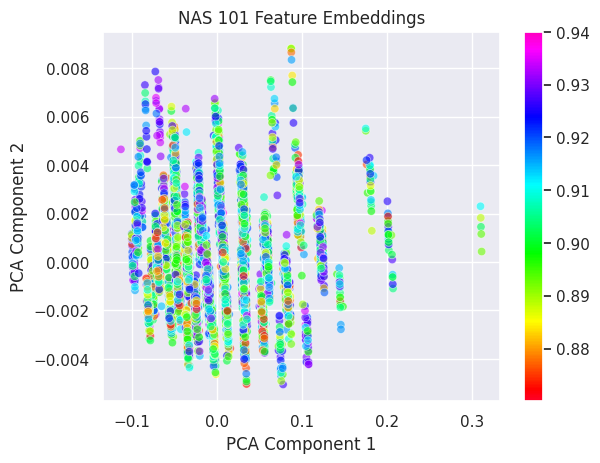

In [37]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
 
plt.title('NAS 101 Feature Embeddings')
new_pca_df = pca_df[pca_df["target"] > 0.87]
ax = sns.scatterplot(x='PCA Component 1', y='PCA Component 2', data=new_pca_df, hue='target', palette='gist_rainbow', alpha=0.6)

norm = plt.Normalize(new_pca_df['target'].min(), new_pca_df['target'].max())
sm = plt.cm.ScalarMappable(cmap="gist_rainbow", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

In [32]:
plt.close()

In [38]:
pca.explained_variance_

array([2.66066076e-03, 3.83418338e-06])

In [41]:
# Reduce from 4 to 2 features with PCA
pca = PCA(n_components=3)
 
# Fit and transform data
pca_features = pca.fit_transform(batch_vals[:40000].cpu())
 
# Create dataframe
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
pca_df['target'] = truth_batch_vals[:40000].cpu()

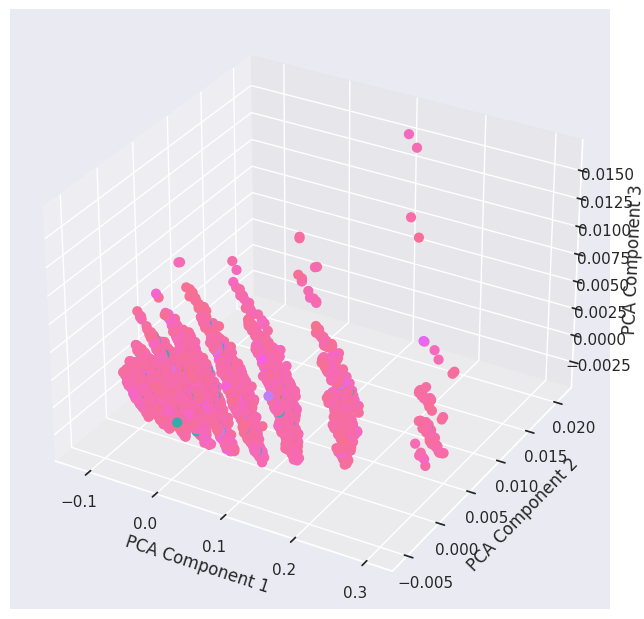

In [42]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

#new_pca_df = pca_df[pca_df["target"] > 0.87]


# generate data
x = pca_df['PCA Component 1'].values
y = pca_df['PCA Component 2'].values
z = pca_df['PCA Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("gist_rainbow", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=pca_df['target'].values, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')


# save
plt.savefig("scatter_hue", bbox_inches='tight')

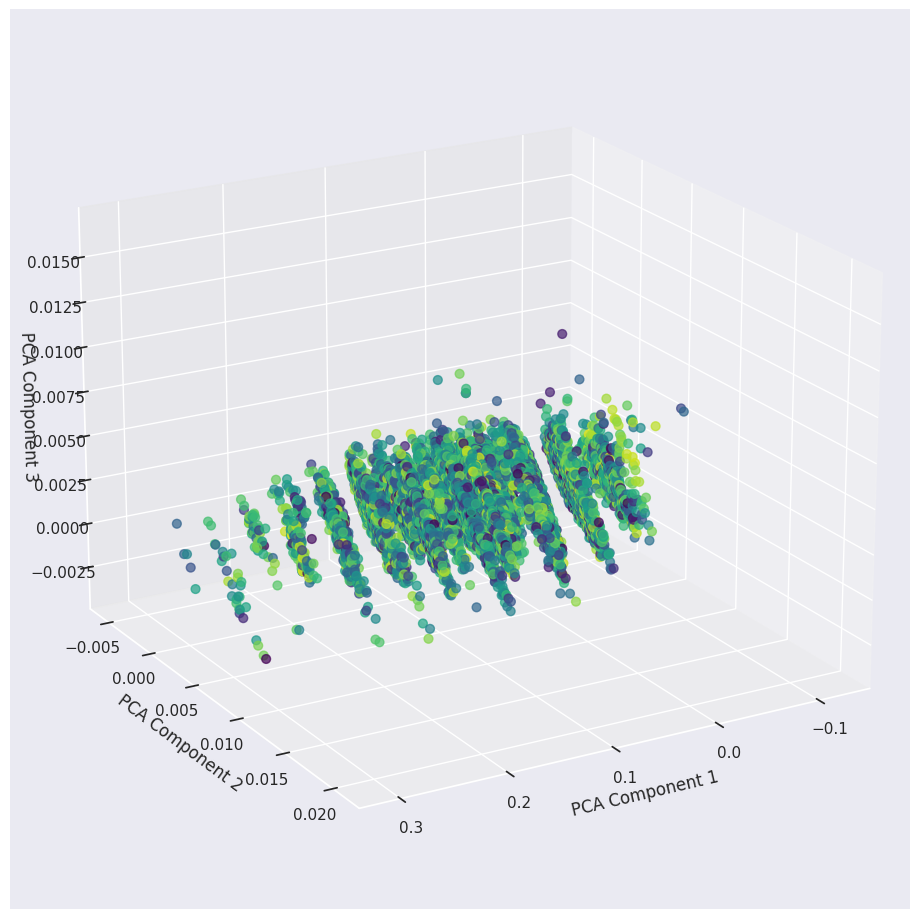

In [48]:
new_pca_df = pca_df[pca_df["target"] > 0.87]


# generate data
x = new_pca_df['PCA Component 1'].values
y = new_pca_df['PCA Component 2'].values
z = new_pca_df['PCA Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=new_pca_df['target'].values, marker='o', cmap=cmap, alpha=0.7)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')


# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [49]:
from sklearn.manifold import TSNE

In [53]:
tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=40, n_iter=600)
results = tsne.fit_transform(batch_vals[:10000].cpu())

In [55]:
# Create dataframe
tsne_df = pd.DataFrame(
    data=results, 
    columns=['Component 1', 'Component 2', 'Component 3'])
tsne_df['target'] = truth_batch_vals[:10000].cpu()

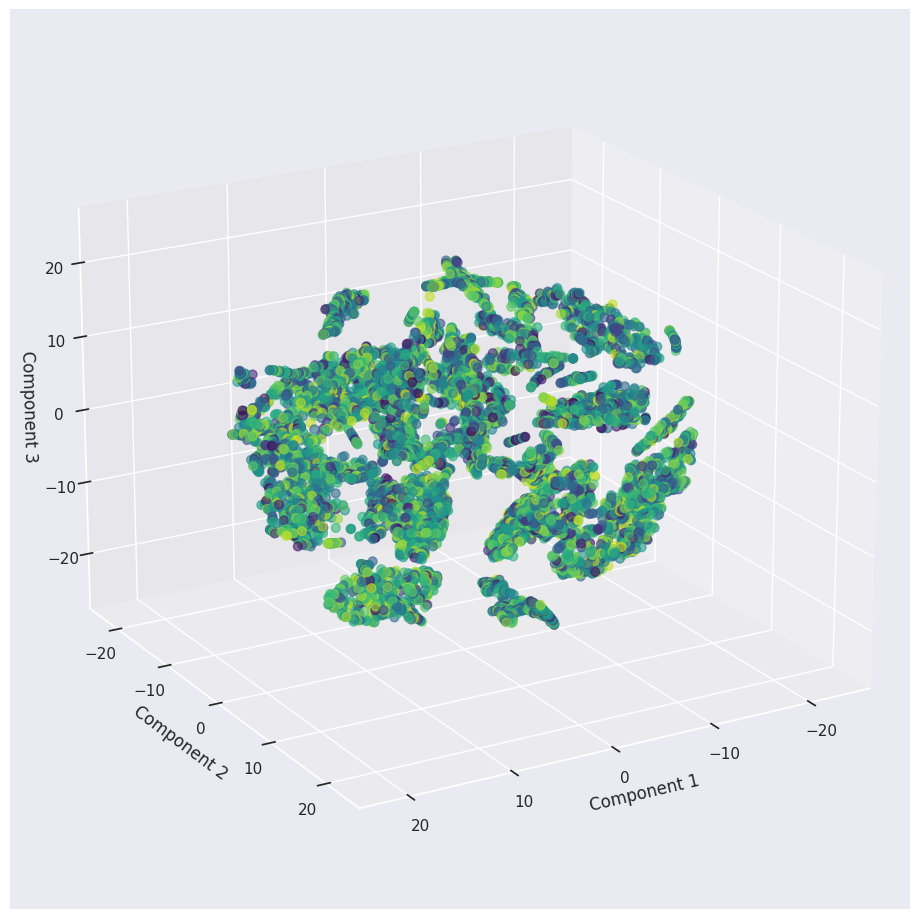

In [57]:
new_tsne_df = tsne_df[tsne_df["target"] > 0.87]


# generate data
x = new_tsne_df['Component 1'].values
y = new_tsne_df['Component 2'].values
z = new_tsne_df['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=new_tsne_df['target'].values, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')